Loading saved GCN model...

📊 Classification Report on Test Set:
              precision    recall  f1-score   support

     Not Buy       0.97      0.62      0.76     48860
         Buy       0.06      0.59      0.11      1938

    accuracy                           0.62     50798
   macro avg       0.52      0.61      0.43     50798
weighted avg       0.94      0.62      0.73     50798


🧪 GCN - F1: 0.1060, AUC: 0.6482, Time: 0.02s
Explaining node 74499...
Running GradExplainer...


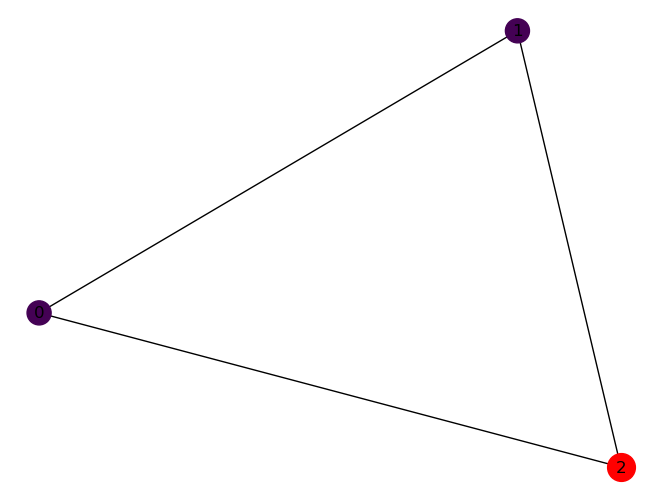

Running GNNExplainer...


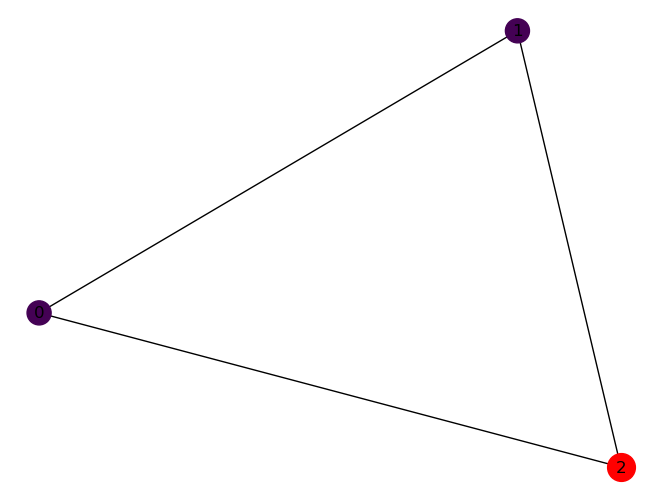

Running GraphLIME...
GraphLIME failed: No node importance returned.
Running PGMExplainer...


c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
  0%|          | 0/1000000 [00:00<?, ?it/s]


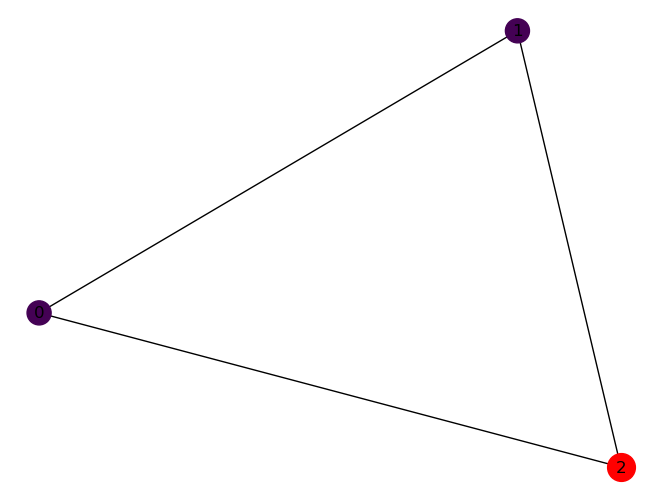


Saved to CSV. Explanation Metrics:
                    GEF
GradExplainer  0.889369
GNNExplainer   0.889685
PGMExplainer   0.889686
GradExplainer  0.323698
GNNExplainer   0.323870
PGMExplainer   0.323871
GradExplainer  0.591304
GNNExplainer   0.697812
GradExplainer  0.696816
GNNExplainer   0.696815
PGMExplainer   0.696815
GradExplainer  0.705121
GNNExplainer   0.704786
PGMExplainer   0.714768
GradExplainer  0.600585
GNNExplainer   0.696815
PGMExplainer   0.696815
GradExplainer  0.886757
GNNExplainer   0.886757
PGMExplainer   0.949068
GradExplainer  0.929509
GNNExplainer   0.929509
PGMExplainer   0.929509

Training Summary:
  Model  F1 Score     AUC  Training Time (sec)
0   GCN     0.106  0.6482                 0.00
1   GCN     0.106  0.6482                 0.01
2   GCN     0.106  0.6482                 0.00
3   GCN     0.106  0.6482                 0.01
4   GCN     0.106  0.6482                 0.00
5   GCN     0.106  0.6482                 0.00
6   GCN     0.106  0.6482               

In [4]:
import os
import random
import time
import torch
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import k_hop_subgraph
from graphxai.utils import Explanation
from graphxai.explainers import GradExplainer, GNNExplainer, GraphLIME, PGMExplainer
from graphxai.gnn_models.node_classification.testing import (
    GCN_3layer_basic, GIN_3layer_basic, GAT_3layer_basic, GSAGE_3layer
)
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# === Load Graph ===
data = torch.load('filtered_graph_2017-11-28.pt')

# === Enrich Features if needed ===
if data.x.shape[1] == 1:
    df = pd.read_csv('UserBehavior_5M_cleaned.csv')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df = df[df['Timestamp'].dt.date == pd.to_datetime('2017-11-28').date()]
    df['Behavior'] = df['Behavior'].map({'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3})

    item_stats = df.groupby('Product_ID').agg(
        behavior_mean=('Behavior', 'mean'),
        behavior_std=('Behavior', 'std'),
        interactions=('Behavior', 'count'),
        unique_users=('User_ID', 'nunique')
    ).fillna(0)

    scaler = StandardScaler()
    enriched_x = torch.tensor(scaler.fit_transform(item_stats.values), dtype=torch.float)
    data.x = enriched_x

x, y = data.x, data.y
edge_index = data.edge_index
train_mask, test_mask = data.train_mask, data.test_mask

# Add missing nodes attribute for visualization
data.nodes = torch.arange(data.num_nodes)

# === Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = int(y.max().item()) + 1
train_idx = train_mask.nonzero(as_tuple=True)[0].to(device)
test_idx = test_mask.nonzero(as_tuple=True)[0].to(device)
x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)

# === Model Choice ===
model_choice = input("Enter model to use (GCN / GIN / GAT / GraphSAGE): ").strip().upper()
model_map = {
    'GCN': GCN_3layer_basic,
    'GIN': GIN_3layer_basic,
    'GAT': GAT_3layer_basic,
    'GRAPHSAGE': GSAGE_3layer
}
if model_choice not in model_map:
    raise ValueError(f"Unsupported model type: {model_choice}")
ModelClass = model_map[model_choice]

# === Train or Load Model ===
model = ModelClass(hidden_channels=64, input_feat=x.size(1), classes=num_classes).to(device)
model_path = f"{model_choice}_model.pt"

class_weights = compute_class_weight('balanced', classes=np.unique(y.cpu()), y=y.cpu().numpy())
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_val_f1, best_epoch, patience = 0, 0, 10
training_start = time.time()

if os.path.exists(model_path):
    print(f"Loading saved {model_choice} model...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Training {model_choice} model from scratch...")
    for epoch in range(1, 201):
        model.train()
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = criterion(out[train_idx], y[train_idx])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            val_out = out[test_idx]
            val_pred = val_out.argmax(dim=1)
            val_f1 = f1_score(y[test_idx].cpu().numpy(), val_pred.cpu().numpy(), zero_division=0)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_epoch = epoch
                torch.save(model.state_dict(), model_path)
                print(f"[Epoch {epoch}] ✅ New best F1: {val_f1:.4f}, Loss: {loss.item():.4f}")
            else:
                print(f"[Epoch {epoch}] F1: {val_f1:.4f}, Loss: {loss.item():.4f} (no improvement)")
            if epoch - best_epoch >= patience:
                print(f"🛑 Early stopping at epoch {epoch}. Best was at epoch {best_epoch} with F1 {best_val_f1:.4f}")
                break
        torch.cuda.empty_cache()

model.load_state_dict(torch.load(model_path))
model.eval()
training_time = time.time() - training_start

# === Evaluation ===
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1)
    y_true = y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()
    y_proba = out[test_idx][:, 1].sigmoid().cpu().numpy() if out.size(1) > 1 else out[test_idx].cpu().numpy()
    print("\n📊 Classification Report on Test Set:")
    print(classification_report(y_true, y_pred, target_names=['Not Buy', 'Buy'], zero_division=0))
    f1 = f1_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_proba)
    except:
        auc = 0.0
    print(f"\n🧪 {model_choice} - F1: {f1:.4f}, AUC: {auc:.4f}, Time: {training_time:.2f}s")

# === Node Explanation ===
correct_buy = test_idx[(pred[test_idx] == y[test_idx]) & (y[test_idx] == 1)]
if len(correct_buy) == 0:
    raise Exception("No correctly predicted Buy node found.")
node_to_explain = random.choice(correct_buy.tolist())
print(f"Explaining node {node_to_explain}...")

subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx=node_to_explain,
    num_hops=1,
    edge_index=edge_index,
    relabel_nodes=True,
    num_nodes=data.num_nodes
)
sub_x = x[subset]

def graph_exp_faith(exp, data):
    if exp.node_imp is None:
        return 0.0
    k = int(len(exp.node_imp) * 0.25)
    top_nodes = exp.node_imp.topk(k).indices
    mask_x = data.x.clone()
    zero_nodes = list(set(range(data.x.shape[0])) - set(top_nodes.tolist()))
    mask_x[zero_nodes] = 0
    out_original = model(data.x, edge_index)[exp.node_idx]
    out_masked = model(mask_x, edge_index)[exp.node_idx]
    return 1 - torch.norm(out_original - out_masked, p=1).item()

# === Explain ===
explainers = {
    'GradExplainer': GradExplainer,
    'GNNExplainer': GNNExplainer,
    'GraphLIME': GraphLIME,
    'PGMExplainer': PGMExplainer
}
results = {}

for name, Explainer in explainers.items():
    print(f"Running {name}...")
    try:
        explainer = Explainer(model=model, criterion=criterion) if name == 'GradExplainer' \
            else Explainer(model=model, explain_graph=False) if name == 'PGMExplainer' \
            else Explainer(model=model)

        input_x = sub_x + 0.0001 * torch.randn_like(sub_x) if name == 'GraphLIME' else sub_x
        exp = explainer.get_explanation_node(
            node_idx=int(mapping[0]),
            x=input_x,
            edge_index=sub_edge_index,
            forward_kwargs={}
        )

        if exp.node_imp is None:
            print(f"{name} failed: No node importance returned.")
            continue

        full_node_imp = torch.zeros(data.num_nodes)
        for i, imp in enumerate(exp.node_imp):
            full_node_imp[subset[i]] = imp

        explanation = Explanation(
            node_imp=full_node_imp,
            node_idx=int(mapping[0])
        )

        # Prepare subgraph data for visualization
        sub_data = Data(x=sub_x, edge_index=sub_edge_index)
        sub_data.nodes = subset  # required by GraphXAI visualization

        # Create Explanation and attach subgraph context
        explanation = Explanation(node_imp=full_node_imp, node_idx=int(mapping[0]))
        explanation.enc_subgraph = sub_data  # ✅ attach subgraph to Explanation

        try:
            explanation.visualize_node(
                num_hops=1,
                graph_data=sub_data,
                additional_hops=0,
                heat_by_prescence=False,
                heat_by_exp=True,
                node_agg_method='sum',
                show_node_labels=True,
                show=True,
                norm_imps=True
            )
            plt.savefig(f"explanation_imgs/{model_choice}_{name}_viz.png")
            plt.close()
        except Exception as e:
            print(f"{name} visualization failed: {e}")

        gef = graph_exp_faith(explanation, data)
        results[name] = {'GEF': gef}
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"{name} failed: {e}")
        continue

# === Save Results ===
df = pd.DataFrame(results).T
csv_path = f"{model_choice}_explanation_metrics.csv"
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path, index_col=0)
    df = pd.concat([df_existing, df])
df.to_csv(csv_path)
print("\nSaved to CSV. Explanation Metrics:")
print(df)

summary = pd.DataFrame([{
    'Model': model_choice,
    'F1 Score': round(f1, 4),
    'AUC': round(auc, 4),
    'Training Time (sec)': round(training_time, 2)
}])
sum_path = f"{model_choice}_runtime_metrics.csv"
if os.path.exists(sum_path):
    summary_existing = pd.read_csv(sum_path)
    summary = pd.concat([summary_existing, summary])
summary.to_csv(sum_path, index=False)
print("\nTraining Summary:")
print(summary)